In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import urllib.request
import tarfile
import os

In [2]:
def setup_device():
    """
    Configura y retorna el dispositivo a usar (GPU o CPU).
    También imprime información útil sobre la GPU si está disponible.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Using GPU: {torch.cuda.get_device_name(0)}')
        print(f'GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')
        # Configurar para usar determinismo en CUDA para reproducibilidad
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        device = torch.device('cpu')
        print('CUDA no disponible, usando CPU')
    return device

In [3]:
def setup_lfw_dataset(base_dir='/home/eric/ml2/data', download=True):
    """
    Configura el dataset LFW.
    """
    # URLs y rutas
    LFW_URL = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
    data_dir = os.path.join(base_dir, 'lfw')
    
    # Crear directorio base si no existe
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    # Verificar si el dataset ya existe
    if not os.path.exists(data_dir) and download:
        print("Descargando dataset LFW...")
        tgz_path = os.path.join(base_dir, 'lfw.tgz')
        urllib.request.urlretrieve(LFW_URL, tgz_path)
        
        print("Extrayendo archivos...")
        with tarfile.open(tgz_path, 'r:gz') as tar:
            tar.extractall(path=base_dir)
        os.remove(tgz_path)
        print("Dataset LFW preparado correctamente.")
    elif not os.path.exists(data_dir) and not download:
        raise RuntimeError("Dataset no encontrado. Establece download=True para descargarlo.")
    else:
        print("Dataset LFW encontrado en disco.")
    
    return data_dir

def get_lfw_loaders(batch_size=32, base_dir='/home/eric/ml2/data', download=True):
    """
    Crea los dataloaders para LFW.
    """
    # Configurar el dataset
    data_dir = setup_lfw_dataset(base_dir, download)
    
    # Definir transformaciones
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    
    # Crear dataset usando ImageFolder
    dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
    
    # Dividir dataset
    total_size = len(dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    # Crear dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4 if torch.cuda.is_available() else 0,
        pin_memory=torch.cuda.is_available()
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4 if torch.cuda.is_available() else 0,
        pin_memory=torch.cuda.is_available()
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4 if torch.cuda.is_available() else 0,
        pin_memory=torch.cuda.is_available()
    )
    
    return train_loader, val_loader, test_loader

In [4]:
"""
Implementación de un Autoencoder Convolucional para Rostros
==========================================================

Este código implementa un autoencoder convolucional específicamente diseñado para el procesamiento
y reconstrucción de imágenes de rostros. Un autoencoder es una red neuronal que aprende a:
1. Codificar (comprimir) la entrada en una representación de menor dimensión
2. Decodificar esta representación para reconstruir la entrada original

Teoría Matemática
----------------
El autoencoder busca encontrar una función de codificación E y una función de decodificación D que minimicen
la pérdida de reconstrucción:

    L(x, D(E(x)))

donde:
- x es la imagen de entrada
- E(x) es la representación codificada (latente)
- D(E(x)) es la imagen reconstruida
- L es la función de pérdida (en este caso, MSE - Error Cuadrático Medio)

En términos matemáticos, el MSE se calcula como:

    MSE = (1/n) * Σ(y_i - ŷ_i)²

donde:
- y_i es el valor real (imagen original)
- ŷ_i es el valor predicho (imagen reconstruida)
- n es el número total de píxeles
"""



class ConvAutoencoder(nn.Module):
    """
    Autoencoder Convolucional para Rostros
    =====================================
    
    Arquitectura del modelo:
    
    Encoder:
    --------
    1. Input (3, 128, 128) -> Conv2d -> (32, 64, 64)   [Reducción espacial: 128->64]
    2. (32, 64, 64) -> Conv2d -> (64, 32, 32)          [Reducción espacial: 64->32]
    3. (64, 32, 32) -> Conv2d -> (128, 16, 16)         [Reducción espacial: 32->16]
    4. (128, 16, 16) -> Conv2d -> (256, 8, 8)          [Reducción espacial: 16->8]
    
    La dimensión del espacio latente es: 256 * 8 * 8 = 16,384
    
    Decoder:
    --------
    Proceso inverso usando ConvTranspose2d para upsampling
    """
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )


    def forward(self, x):
        """
        Forward pass del modelo.
        
        Proceso:
        1. La imagen pasa por el encoder -> representación comprimida
        2. La representación comprimida pasa por el decoder -> reconstrucción
        """
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 3. Función de entrenamiento
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Entrena el modelo por una época.
    """
    model.train()
    total_loss = 0
    
    for batch, _ in tqdm(train_loader, desc="Training"):  # Ignoramos las etiquetas
        batch = batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    """
    Valida el modelo.
    """
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch, _ in tqdm(val_loader, desc="Validating"):  # Ignoramos las etiquetas
            batch = batch.to(device)
            outputs = model(batch)
            loss = criterion(outputs, batch)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

def train_autoencoder(model, train_loader, val_loader, num_epochs, device):
    """
    Función de Entrenamiento
    =======================
    
    Proceso de entrenamiento:
    1. Forward pass: genera predicción
    2. Calcula pérdida (MSE entre original y reconstrucción)
    3. Backward pass: calcula gradientes
    4. Actualiza pesos mediante optimizador Adam
    
    El optimizador Adam combina las ventajas de:
    - AdaGrad: maneja gradientes dispersos
    - RMSProp: maneja gradientes no estacionarios
    
    La tasa de aprendizaje de 1e-3 es típica para Adam y suele dar buenos resultados.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {train_loss:.6f}')
        print(f'Validation Loss: {val_loss:.6f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, 'best_autoencoder.pth')
    
    return train_losses, val_losses

def visualize_results(model, test_loader, device, num_images=5):
    """
    Visualización de Resultados
    ==========================
    
    Muestra comparación entre:
    - Imágenes originales
    - Sus reconstrucciones por el autoencoder
    
    Esto permite evaluar visualmente:
    1. Calidad de la reconstrucción
    2. Qué características preserva mejor el modelo
    3. Qué tipos de artefactos o distorsiones introduce
    """
    model.eval()
    
    with torch.no_grad():
        # Obtener un batch de imágenes
        batch, _ = next(iter(test_loader))  # Ignoramos las etiquetas
        batch = batch.to(device)
        outputs = model(batch)
        
        n = min(num_images, batch.size(0))
        
        plt.figure(figsize=(12, 4))
        for i in range(n):
            # Original
            plt.subplot(2, n, i + 1)
            plt.imshow(batch[i].cpu().permute(1, 2, 0))
            plt.axis('off')
            if i == 0:
                plt.title('Original')
            
            # Reconstrucción
            plt.subplot(2, n, i + n + 1)
            plt.imshow(outputs[i].cpu().permute(1, 2, 0))
            plt.axis('off')
            if i == 0:
                plt.title('Reconstruida')
        
        plt.tight_layout()
        plt.show()

# def train_autoencoder(model, train_loader, val_loader, num_epochs, device):
#     """
#     Función de Entrenamiento
#     =======================
    
#     Proceso de entrenamiento:
#     1. Forward pass: genera predicción
#     2. Calcula pérdida (MSE entre original y reconstrucción)
#     3. Backward pass: calcula gradientes
#     4. Actualiza pesos mediante optimizador Adam
    
#     El optimizador Adam combina las ventajas de:
#     - AdaGrad: maneja gradientes dispersos
#     - RMSProp: maneja gradientes no estacionarios
    
#     La tasa de aprendizaje de 1e-3 es típica para Adam y suele dar buenos resultados.
#     """
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
#     # Para guardar el mejor modelo
#     best_val_loss = float('inf')
    
#     # Para graficar el progreso
#     train_losses = []
#     val_losses = []
    
#     for epoch in range(num_epochs):
#         # Entrenamiento
#         train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        
#         # Validación
#         val_loss = validate(model, val_loader, criterion, device)
        
#         # Guardar pérdidas para graficar
#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
        
#         print(f'Epoch [{epoch+1}/{num_epochs}]')
#         print(f'Training Loss: {train_loss:.6f}')
#         print(f'Validation Loss: {val_loss:.6f}')
        
#         # Guardar el mejor modelo
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_loss': val_loss,
#             }, 'best_autoencoder.pth')
#     # Mostrar uso de memoria GPU si está disponible
#     if device.type == 'cuda':
#         print(f'GPU Memory Allocated: {torch.cuda.memory_allocated(0)/1e9:.2f} GB')
#         print(f'GPU Memory Cached: {torch.cuda.memory_reserved(0)/1e9:.2f} GB')
    
#     # Graficar progreso del entrenamiento
#     plt.figure(figsize=(10, 5))
#     plt.plot(train_losses, label='Training Loss')
#     plt.plot(val_losses, label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.savefig('training_progress.png')
#     plt.close()
    
#     return train_losses, val_losses


# def visualize_results(model, test_loader, device, num_images=5):
#     """
#     Visualización de Resultados
#     ==========================
    
#     Muestra comparación entre:
#     - Imágenes originales
#     - Sus reconstrucciones por el autoencoder
    
#     Esto permite evaluar visualmente:
#     1. Calidad de la reconstrucción
#     2. Qué características preserva mejor el modelo
#     3. Qué tipos de artefactos o distorsiones introduce
#     """
#     model.eval()
    
#     # Obtener un batch de imágenes
#     with torch.no_grad():
#         batch = next(iter(test_loader))
#         batch = batch.to(device)
#         outputs = model(batch)
        
#         # Mostrar solo el número especificado de imágenes
#         n = min(num_images, batch.size(0))
        
#         plt.figure(figsize=(12, 4))
        
#         for i in range(n):
#             # Original
#             plt.subplot(2, n, i + 1)
#             plt.imshow(batch[i].cpu().permute(1, 2, 0))
#             plt.axis('off')
#             if i == 0:
#                 plt.title('Original')
            
#             # Reconstrucción
#             plt.subplot(2, n, i + n + 1)
#             plt.imshow(outputs[i].cpu().permute(1, 2, 0))
#             plt.axis('off')
#             if i == 0:
#                 plt.title('Reconstruida')
        
#         plt.savefig('reconstruction_results.png')
#         plt.close()



Using device: cuda
Dataset LFW encontrado en disco.


Validating: 100%|██████████| 42/42 [00:00<00:00, 51.60it/s]


Epoch [1/2]
Training Loss: 0.024121
Validation Loss: 0.011092


Validating: 100%|██████████| 42/42 [00:00<00:00, 53.75it/s]

Epoch [2/2]
Training Loss: 0.009044
Validation Loss: 0.007928


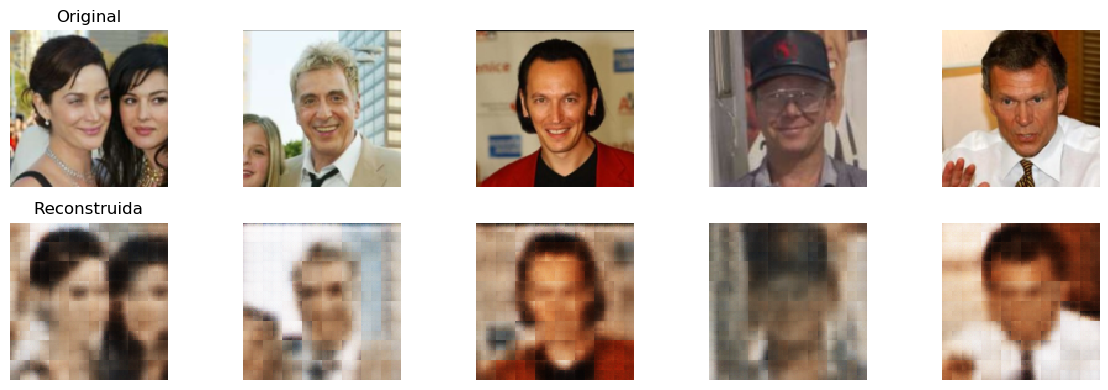

In [5]:
def main():
    """
    Función Principal
    ================
    
    Flujo del programa:
    1. Configuración del dispositivo (GPU/CPU)
    2. Preparación del dataset y dataloader
    3. Inicialización del modelo
    4. Entrenamiento
    5. Visualización de resultados
    6. Guardado del modelo
    """
    # Configurar dispositivo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Obtener dataloaders
    train_loader, val_loader, test_loader = get_lfw_loaders(
        batch_size=32,
        download=True
    )
    
    # Crear modelo y moverlo al dispositivo
    model = ConvAutoencoder().to(device)
    
    # Entrenar modelo
    train_losses, val_losses = train_autoencoder(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=2,
        device=device
    )
    
    # Visualizar resultados
    visualize_results(model, test_loader, device)


if __name__ == '__main__':
    main()